In [8]:
import matplotlib.pyplot as plt
import numpy as np
import cupy as cp
import cupyx.scipy.fft as cufft
from time import time

import obspy
from obspy import UTCDateTime
from obspy.clients.fdsn import Client

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [168]:
import covseisnet as csn
from covseisnet.cudaseisnet import (
    coherence,
    calculate,
    stft,
    calculate_eigenvalues,
    calculate_eigenvectors,
    xcov,
    flatten
)


In [153]:
# example from csn docs (plot_example_5.py)


# # download data from the YA Undervolc seismic network with RESIF Seismic data portal
client = Client("IRIS")
signal_duration_sec = 3600 #24 * 3600
t = UTCDateTime("2020-10-14T00:00:00.00")
list_stations = [
    "BAR",
    "BEL",
    "ARV",
    "ADO",
]
stream = csn.arraystream.ArrayStream()
for sta in list_stations:
    print(sta)
    st = client.get_waveforms(
        network="CI", station=sta, location="*", channel="HHZ",
        starttime=t, endtime=t + signal_duration_sec
    )
    stream.append(st[0])

#stream = csn.arraystream.ArrayStream(obspy.read())
raw_stream = stream.copy()

# create plot #1 - no preprocessing

# downsample data to 25 Hz
stream.decimate(4)

# synchronize data
stream = stream.synchronize(start=stream[0].stats.starttime, duration_sec=signal_duration_sec, method="linear")



BAR
BEL
ARV
ADO


In [154]:
stream

4 Trace(s) in Stream:
CI.BAR..HHZ | 2020-10-14T00:00:00.008393Z - 2020-10-14T00:59:59.968393Z | 25.0 Hz, 90000 samples
CI.BEL..HHZ | 2020-10-14T00:00:00.008393Z - 2020-10-14T00:59:59.968393Z | 25.0 Hz, 90000 samples
CI.ARV..HHZ | 2020-10-14T00:00:00.008393Z - 2020-10-14T00:59:59.968393Z | 25.0 Hz, 90000 samples
CI.ADO..HHZ | 2020-10-14T00:00:00.008393Z - 2020-10-14T00:59:59.968393Z | 25.0 Hz, 90000 samples

In [256]:
# calculate covariance from stream
window_duration_sec = 10
average = 15
t0 = time()
times, frequencies, covariances = csn.covariancematrix.calculate(
    stream, window_duration_sec, average
)

# calculate spectral width
spectral_width_cpu = covariances.coherence(kind="spectral_width")

print(f"Total time {(time()-t0):.1f} s")

Total time 1.7 s


In [156]:
# create gpu matrix
# free memory
mempool = cp.get_default_memory_pool()
mempool.free_all_blocks()
array = cp.stack([cp.asarray(trace.data) for trace in stream.traces])#.astype("float32")
array.device, array.shape

(<CUDA Device 0>, (4, 90000))

In [282]:
# gpu covseisnet

window_duration_sec = 10
average = 15
fs = stream[0].stats.sampling_rate

t0 = time()

timesg, frequenciesg, covariancesg = calculate(
    array, window_duration_sec, average, fs
)
# calculate spectral width
t1 = time()
spectral_width_gpu = coherence(covariances, type="spectral width")

tend = time()
print(f"coherence time {(tend-t1):.1f} s")
print(f"Total time {(tend-t0):.1f} s")

torch.Size([50399, 4])
coherence time 0.0 s
Total time 0.1 s


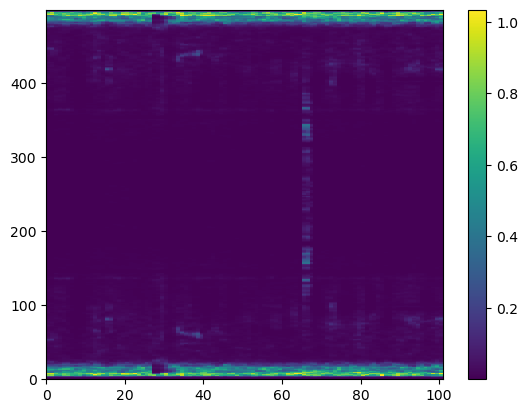

In [283]:
plt.pcolormesh(spectral_width_cpu.T, cmap="viridis")
plt.colorbar();

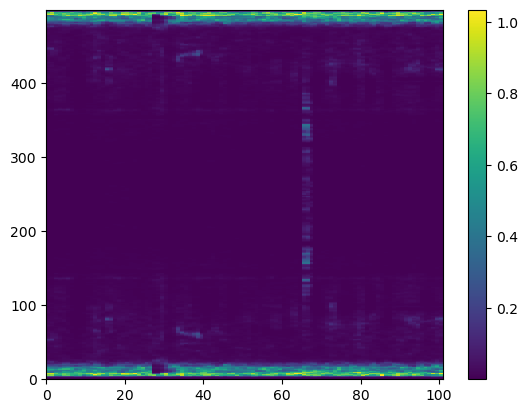

In [284]:
plt.pcolormesh(spectral_width_gpu.get().T, cmap="viridis")
plt.colorbar();

In [206]:
ts, freqs, covs = csn.covariancematrix.calculate(stream, window_duration_sec,average)

In [214]:
tsg, freqsg, covsg = calculate(array, window_duration_sec, average, sr=25)

In [217]:
covs == covsg.get()

ValueError: operands could not be broadcast together with shapes (1449,249,4,4) (101,499,4,4) 

In [223]:
covs.shape, covsg.shape, freqs.shape, freqsg.shape

((1449, 249, 4, 4), (101, 499, 4, 4), (250,), (500,))

In [221]:
ts.shape, tsg.shape

((1450,), (102,))

In [224]:
window_duration_sec*fs

250.0

In [232]:
_,_,spectra = stft(array, window_duration_sec, fs)

stacked_windows shape: (4, 719, 250)


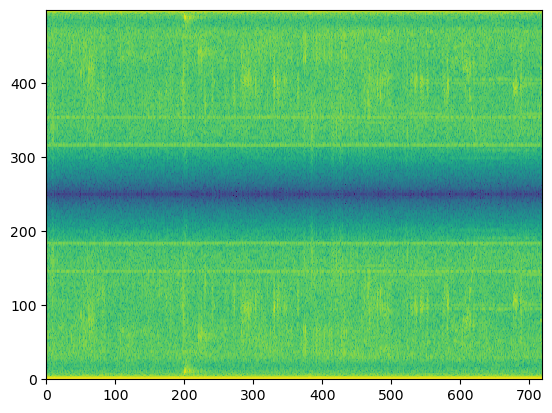

In [240]:
plt.pcolormesh(np.log(cp.abs(spectra[3]).get()).T)

In [228]:
npts = int(window_duration_sec * fs)
step = npts // 2 

spectra * cp.hanning(npts)

ValueError: operands could not be broadcast together with shapes (4, 719, 499) (250,)

In [64]:
def sliding_window(X, winlen, step):
    """Creates sliding windows across second dimension of an array"""
    view = sliding_window_view(X, winlen, axis=1)[:,::step,...]
    return cp.asarray(view)

def sliding_window_view(x, window_shape, axis=None, *,
                        subok=False, writeable=False):
    """
    Create a sliding window view into the array with the given window shape.

    Also known as rolling or moving window, the window slides across all
    dimensions of the array and extracts subsets of the array at all window
    positions.


    Parameters
    ----------
    x : array_like
        Array to create the sliding window view from.
    window_shape : int or tuple of int
        Size of window over each axis that takes part in the sliding window.
        If `axis` is not present, must have same length as the number of input
        array dimensions. Single integers `i` are treated as if they were the
        tuple `(i,)`.
    axis : int or tuple of int, optional
        Axis or axes along which the sliding window is applied.
        By default, the sliding window is applied to all axes and
        `window_shape[i]` will refer to axis `i` of `x`.
        If `axis` is given as a `tuple of int`, `window_shape[i]` will refer to
        the axis `axis[i]` of `x`.
        Single integers `i` are treated as if they were the tuple `(i,)`.
    subok : bool, optional
        If True, sub-classes will be passed-through, otherwise the returned
        array will be forced to be a base-class array (default).
    writeable : bool, optional -- not supported
        When true, allow writing to the returned view. The default is false,
        as this should be used with caution: the returned view contains the
        same memory location multiple times, so writing to one location will
        cause others to change.

    Returns
    -------
    view : ndarray
        Sliding window view of the array. The sliding window dimensions are
        inserted at the end, and the original dimensions are trimmed as
        required by the size of the sliding window.
        That is, ``view.shape = x_shape_trimmed + window_shape``, where
        ``x_shape_trimmed`` is ``x.shape`` with every entry reduced by one less
        than the corresponding window size.


    See also
    --------
    numpy.lib.stride_tricks.as_strided

    Notes
    --------
    This function is adapted from numpy.lib.stride_tricks.as_strided.

    Examples
    --------
    >>> x = _cupy.arange(6)
    >>> x.shape
    (6,)
    >>> v = sliding_window_view(x, 3)
    >>> v.shape
    (4, 3)
    >>> v
    array([[0, 1, 2],
           [1, 2, 3],
           [2, 3, 4],
           [3, 4, 5]])

    """
    import cupy as _cupy
    window_shape = (tuple(window_shape)
                    if np.iterable(window_shape)
                    else (window_shape,))

    # writeable is not supported:
    if writeable:
        raise NotImplementedError("Writeable views are not supported.")

    # first convert input to array, possibly keeping subclass
    x = _cupy.array(x, copy=False, subok=subok)

    window_shape_array = _cupy.array(window_shape)
    for dim in window_shape_array:
        if dim < 0:
            raise ValueError('`window_shape` cannot contain negative values')

    if axis is None:
        axis = tuple(range(x.ndim))
        if len(window_shape) != len(axis):
            raise ValueError(f'Since axis is `None`, must provide '
                             f'window_shape for all dimensions of `x`; '
                             f'got {len(window_shape)} window_shape elements '
                             f'and `x.ndim` is {x.ndim}.')
    else:
        axis = _cupy._core.internal._normalize_axis_indices(axis, x.ndim)
        if len(window_shape) != len(axis):
            raise ValueError(f'Must provide matching length window_shape and '
                             f'axis; got {len(window_shape)} window_shape '
                             f'elements and {len(axis)} axes elements.')

    out_strides = x.strides + tuple(x.strides[ax] for ax in axis)

    # note: same axis can be windowed repeatedly
    x_shape_trimmed = list(x.shape)
    for ax, dim in zip(axis, window_shape):
        if x_shape_trimmed[ax] < dim:
            raise ValueError(
                'window shape cannot be larger than input array shape')
        x_shape_trimmed[ax] -= dim - 1
    out_shape = tuple(x_shape_trimmed) + window_shape
    return _cupy.lib.stride_tricks.as_strided(x, strides=out_strides, shape=out_shape)

In [67]:
stacked_windows = sliding_window(array, 50,25)

In [70]:
cufft.fft(stacked_windows)

array([[[-9.44092766e+03+0.00000000e+00j,
          1.28946124e+03-4.32577503e+03j,
         -2.11887430e+02-1.27644666e+03j, ...,
          1.26145055e+02+6.90570435e+02j,
         -2.11887430e+02+1.27644666e+03j,
          1.28946124e+03+4.32577503e+03j],
        [-1.40868893e+04+0.00000000e+00j,
          7.31447403e+02+1.18275216e+03j,
          2.74599995e+02+1.94953372e+02j, ...,
          2.11431766e+02-1.34469195e+02j,
          2.74599995e+02-1.94953372e+02j,
          7.31447403e+02-1.18275216e+03j],
        [-6.57647520e+03+0.00000000e+00j,
          1.09352423e+03+3.80582985e+03j,
         -1.37575523e+02+1.87007803e+03j, ...,
         -2.68604772e+02-1.30190852e+03j,
         -1.37575523e+02-1.87007803e+03j,
          1.09352423e+03-3.80582985e+03j],
        ...,
        [-7.81147298e+03+0.00000000e+00j,
          1.08487334e+03-7.89224928e+02j,
          4.42611143e+02-3.09597256e+01j, ...,
          1.82617966e+02+3.98977428e+02j,
          4.42611143e+02+3.09597256e+01j

TypeError: 'module' object is not callable

In [61]:
_, _, spectra = stft(array, window_duration_sec, 25)

(3, 2, 999)


In [62]:
spectra.shape

(3, 2, 999)

In [64]:
cufft.fft(array[0])

array([-3.39736508e+03+0.00000000e+00j, -1.00415913e+04-9.72649471e+01j,
       -8.41714569e+03-4.53387735e+03j, -2.64151908e+04+1.21551746e+04j,
       -1.25169244e+04-3.07573835e+03j,  3.82740860e+04+2.79310771e+04j,
        4.23505649e+04+4.62325453e+04j,  3.49834280e+03-4.07856637e+04j,
        1.95030809e+04+2.35365114e+04j, -1.71340805e+04+1.64776399e+04j,
        3.39971259e+03-9.25519481e+03j,  1.12221722e+04+9.26396606e+03j,
       -5.32294292e+03-5.17031803e+03j,  1.17853168e+03+1.10155632e+04j,
        6.35138611e+03-2.77442711e+03j, -1.71294078e+03+5.63280607e+03j,
       -2.57081107e+03-1.96152084e+03j, -2.68088199e+03-4.56754452e+03j,
       -2.01258175e+03+2.16659398e+03j, -2.13337931e+03+2.72117083e+03j,
       -5.40654162e+02-1.51500427e+03j,  6.51367548e+02-1.13405513e+03j,
       -4.60017980e+03+2.20080621e+02j, -6.15577713e+03-9.30205112e+02j,
       -2.52422379e+02+3.96519938e+03j,  2.85862183e+03+1.00317820e+03j,
       -5.32211154e+02-5.24428669e+03j, -4.76266162

In [55]:
array[0]

array([0.00000000e+00, 3.29537873e-04, 1.78080635e-02, ...,
       3.61159296e+01, 3.61159296e+01, 3.61159296e+01])

In [35]:
array.shape

(3, 2160000)

In [40]:
csn.arraystream.ArrayStream(raw_stream)[0].data

array([0.        , 0.00694644, 0.07597424, ..., 1.93449584, 0.98196204,
       0.44196924])

In [6]:
winlen = 50
skip = 25

# the number of windows in an array of length N is N/skip, but then only as many as will fit in the array
cp.lib.stride_tricks.as_strided(array, shape=(), strides=(3,10))

ValueError: len(shape) != len(strides)

In [7]:
left_edges = np.arange(len(array[0]))[: 1 - winlen : skip]
nwins = len(left_edges)
nwins

29

In [8]:
left_edges

array([  0,  25,  50,  75, 100, 125, 150, 175, 200, 225, 250, 275, 300,
       325, 350, 375, 400, 425, 450, 475, 500, 525, 550, 575, 600, 625,
       650, 675, 700])

In [9]:
cp.lib.stride_tricks.as_strided(array.T, shape=(nwins,winlen,3), strides=(1,winlen,1))

CUDARuntimeError: cudaErrorMisalignedAddress: misaligned address

In [92]:
np.arange(len(array))

array([0, 1, 2])

In [109]:
array.strides

(6000, 8)

In [111]:
array.shape

(3, 750)

In [37]:
array = np.arange(100)

In [22]:
np.lib.stride_tricks.sliding_window_view(array,10)[::5,:]

array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9],
       [ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14],
       [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
       [15, 16, 17, 18, 19, 20, 21, 22, 23, 24],
       [20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
       [25, 26, 27, 28, 29, 30, 31, 32, 33, 34],
       [30, 31, 32, 33, 34, 35, 36, 37, 38, 39],
       [35, 36, 37, 38, 39, 40, 41, 42, 43, 44],
       [40, 41, 42, 43, 44, 45, 46, 47, 48, 49],
       [45, 46, 47, 48, 49, 50, 51, 52, 53, 54],
       [50, 51, 52, 53, 54, 55, 56, 57, 58, 59],
       [55, 56, 57, 58, 59, 60, 61, 62, 63, 64],
       [60, 61, 62, 63, 64, 65, 66, 67, 68, 69],
       [65, 66, 67, 68, 69, 70, 71, 72, 73, 74],
       [70, 71, 72, 73, 74, 75, 76, 77, 78, 79],
       [75, 76, 77, 78, 79, 80, 81, 82, 83, 84],
       [80, 81, 82, 83, 84, 85, 86, 87, 88, 89],
       [85, 86, 87, 88, 89, 90, 91, 92, 93, 94],
       [90, 91, 92, 93, 94, 95, 96, 97, 98, 99]])

In [54]:
def sliding_window(X, winlen, step):
    """Creates sliding windows across second dimension of an array"""
    view = np.lib.stride_tricks.sliding_window_view(X, winlen, axis=1)[:,::step,...]
    return np.asarray(view)

In [55]:
array = np.stack([np.arange(50)+2, np.arange(50)])
sliding_window(array, 10, 5).shape

(2, 9, 10)

In [56]:
array = np.stack([np.asarray(trace.data) for trace in stream.traces])#.astype("float32")
array.shape

(3, 750)

In [57]:
sliding_window(array, 50, 25).shape

(3, 29, 50)

In [58]:
cp.asarray?

Signature: cp.asarray(a, dtype=None, order=None)
Docstring:
Converts an object to array.

This is equivalent to ``array(a, dtype, copy=False, order=order)``.

Args:
    a: The source object.
    dtype: Data type specifier. It is inferred from the input by default.
    order ({'C', 'F', 'A', 'K'}):
        Whether to use row-major (C-style) or column-major (Fortran-style)
        memory representation. Defaults to ``'K'``. ``order`` is ignored
        for objects that are not :class:`cupy.ndarray`, but have the
        ``__cuda_array_interface__`` attribute.

Returns:
    cupy.ndarray: An array on the current device. If ``a`` is already on
    the device, no copy is performed.

.. note::
   If ``a`` is an `numpy.ndarray` instance that contains big-endian data,
   this function automatically swaps its byte order to little-endian,
   which is the NVIDIA and AMD GPU architecture's native use.

.. seealso:: :func:`numpy.asarray`
File:      /opt/conda/envs/python/lib/python3.11/site-packages